In [167]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [168]:
file = '..\data\external\Legally_Operating_Businesses.csv'
df = pd.read_csv(file)
df = df[df['Latitude'].isna() == False]
df = df[df['Business Name'].isna()==False]
df = df[df['Address State']=='NY']
df['License Creation Date'] = pd.to_datetime(df['License Creation Date'], format = '%m/%d/%Y')
df['License Expiration Date'] = pd.to_datetime(df['License Expiration Date'], format = '%m/%d/%Y')
df['License Status'] = df['License Status']=='Active'
df['License Status'] = df['License Status'].astype('int')
drop_cols = ['DCA License Number', 'License Type', 'Business Name', 'Business Name 2', 'Address Building', 'Address Street Name', 'Secondary Address Street Name', 'Address City', 'Address State', 'Address ZIP', 'Contact Phone Number', 'Address Borough','Borough Code','Community Board','Council District','BIN','BBL','NTA','Census Tract','Detail','Location']
df.drop(labels = drop_cols, axis=1, inplace = True)
df = df[df['Longitude'] > -76]
df.reset_index(drop = True, inplace = True)
df.head()

C:\Users\JackW\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,License Expiration Date,License Status,License Creation Date,Industry,Longitude,Latitude
0,2022-06-30,1,2007-01-02,Electronic & Appliance Service,-73.835446,40.838469
1,2022-05-01,1,2018-10-31,Employment Agency,-73.795002,40.710524
2,2022-06-30,1,2015-10-27,Electronic & Appliance Service,-74.010425,40.645018
3,2022-05-01,1,2012-07-13,Employment Agency,-73.969382,40.792751
4,2022-06-30,1,2012-01-10,Electronic & Appliance Service,-73.825319,40.733833


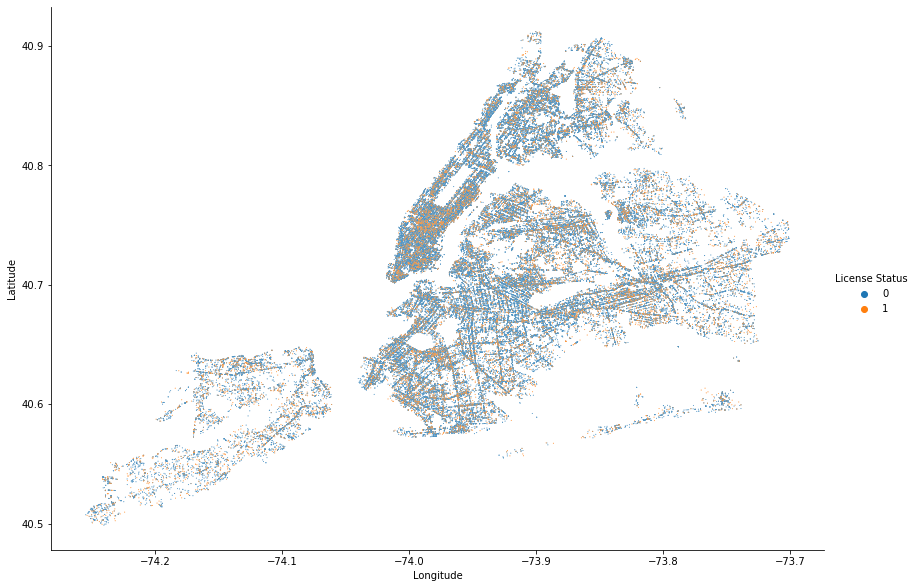

In [159]:
sns.relplot(x=df['Longitude'],y=df['Latitude'],s=1,hue=df['License Status'],height=8.27, aspect=11.7/8.27)

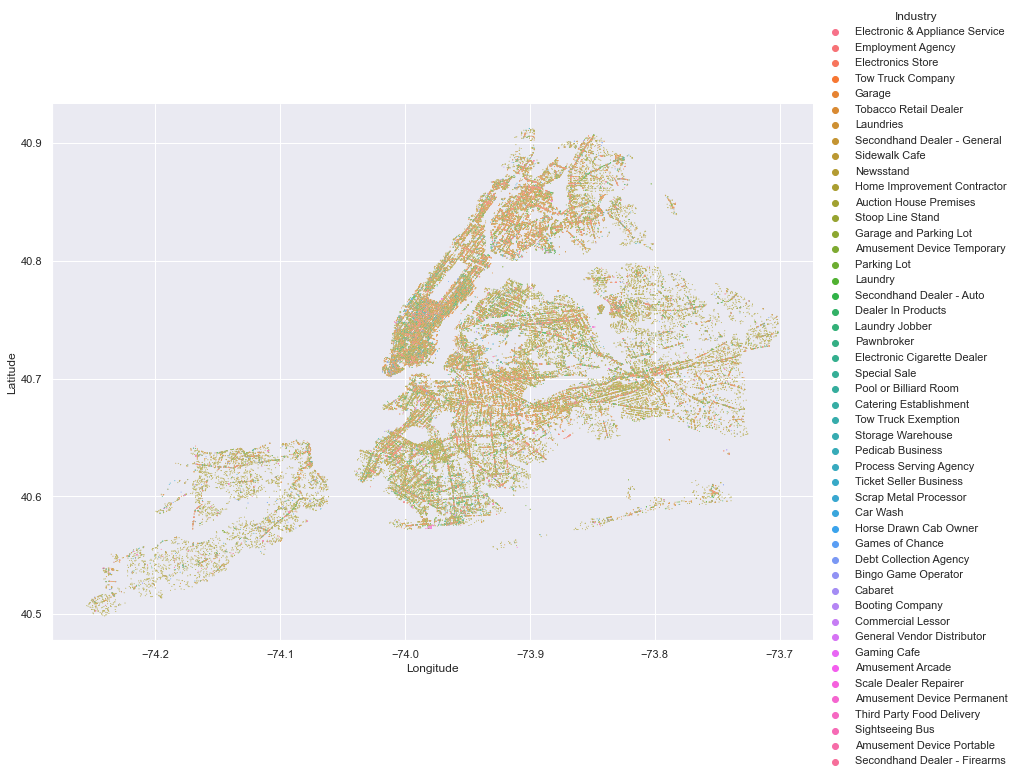

In [190]:
sns.relplot(x=df['Longitude'],y=df['Latitude'],s=1,hue=df['Industry'],height=8.27, aspect=11.7/8.27)

<AxesSubplot:>

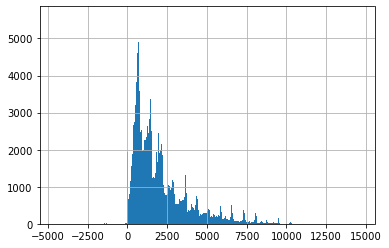

In [169]:
# How is the difference between creation and expiration date distributed?
#There are spikes at around each 1 year mark.
df['date_diffs']=(df['License Expiration Date']-df['License Creation Date']).dt.days
df['date_diffs'].hist(bins=400)

In [170]:
# Around 200 entries have impossible creation/expiration dates, all but 1 of these are listed as 'expired'

df=df[df['date_diffs']>0]

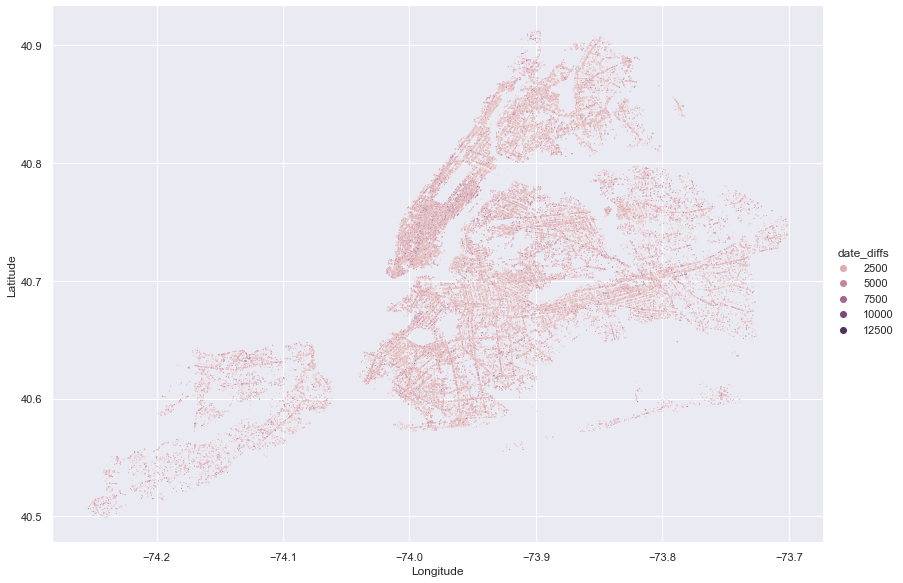

In [194]:
sns.relplot(x=df['Longitude'],y=df['Latitude'],s=1,hue=df['date_diffs'],height=8.27, aspect=11.7/8.27)

<AxesSubplot:xlabel='date_diffs', ylabel='Industry'>

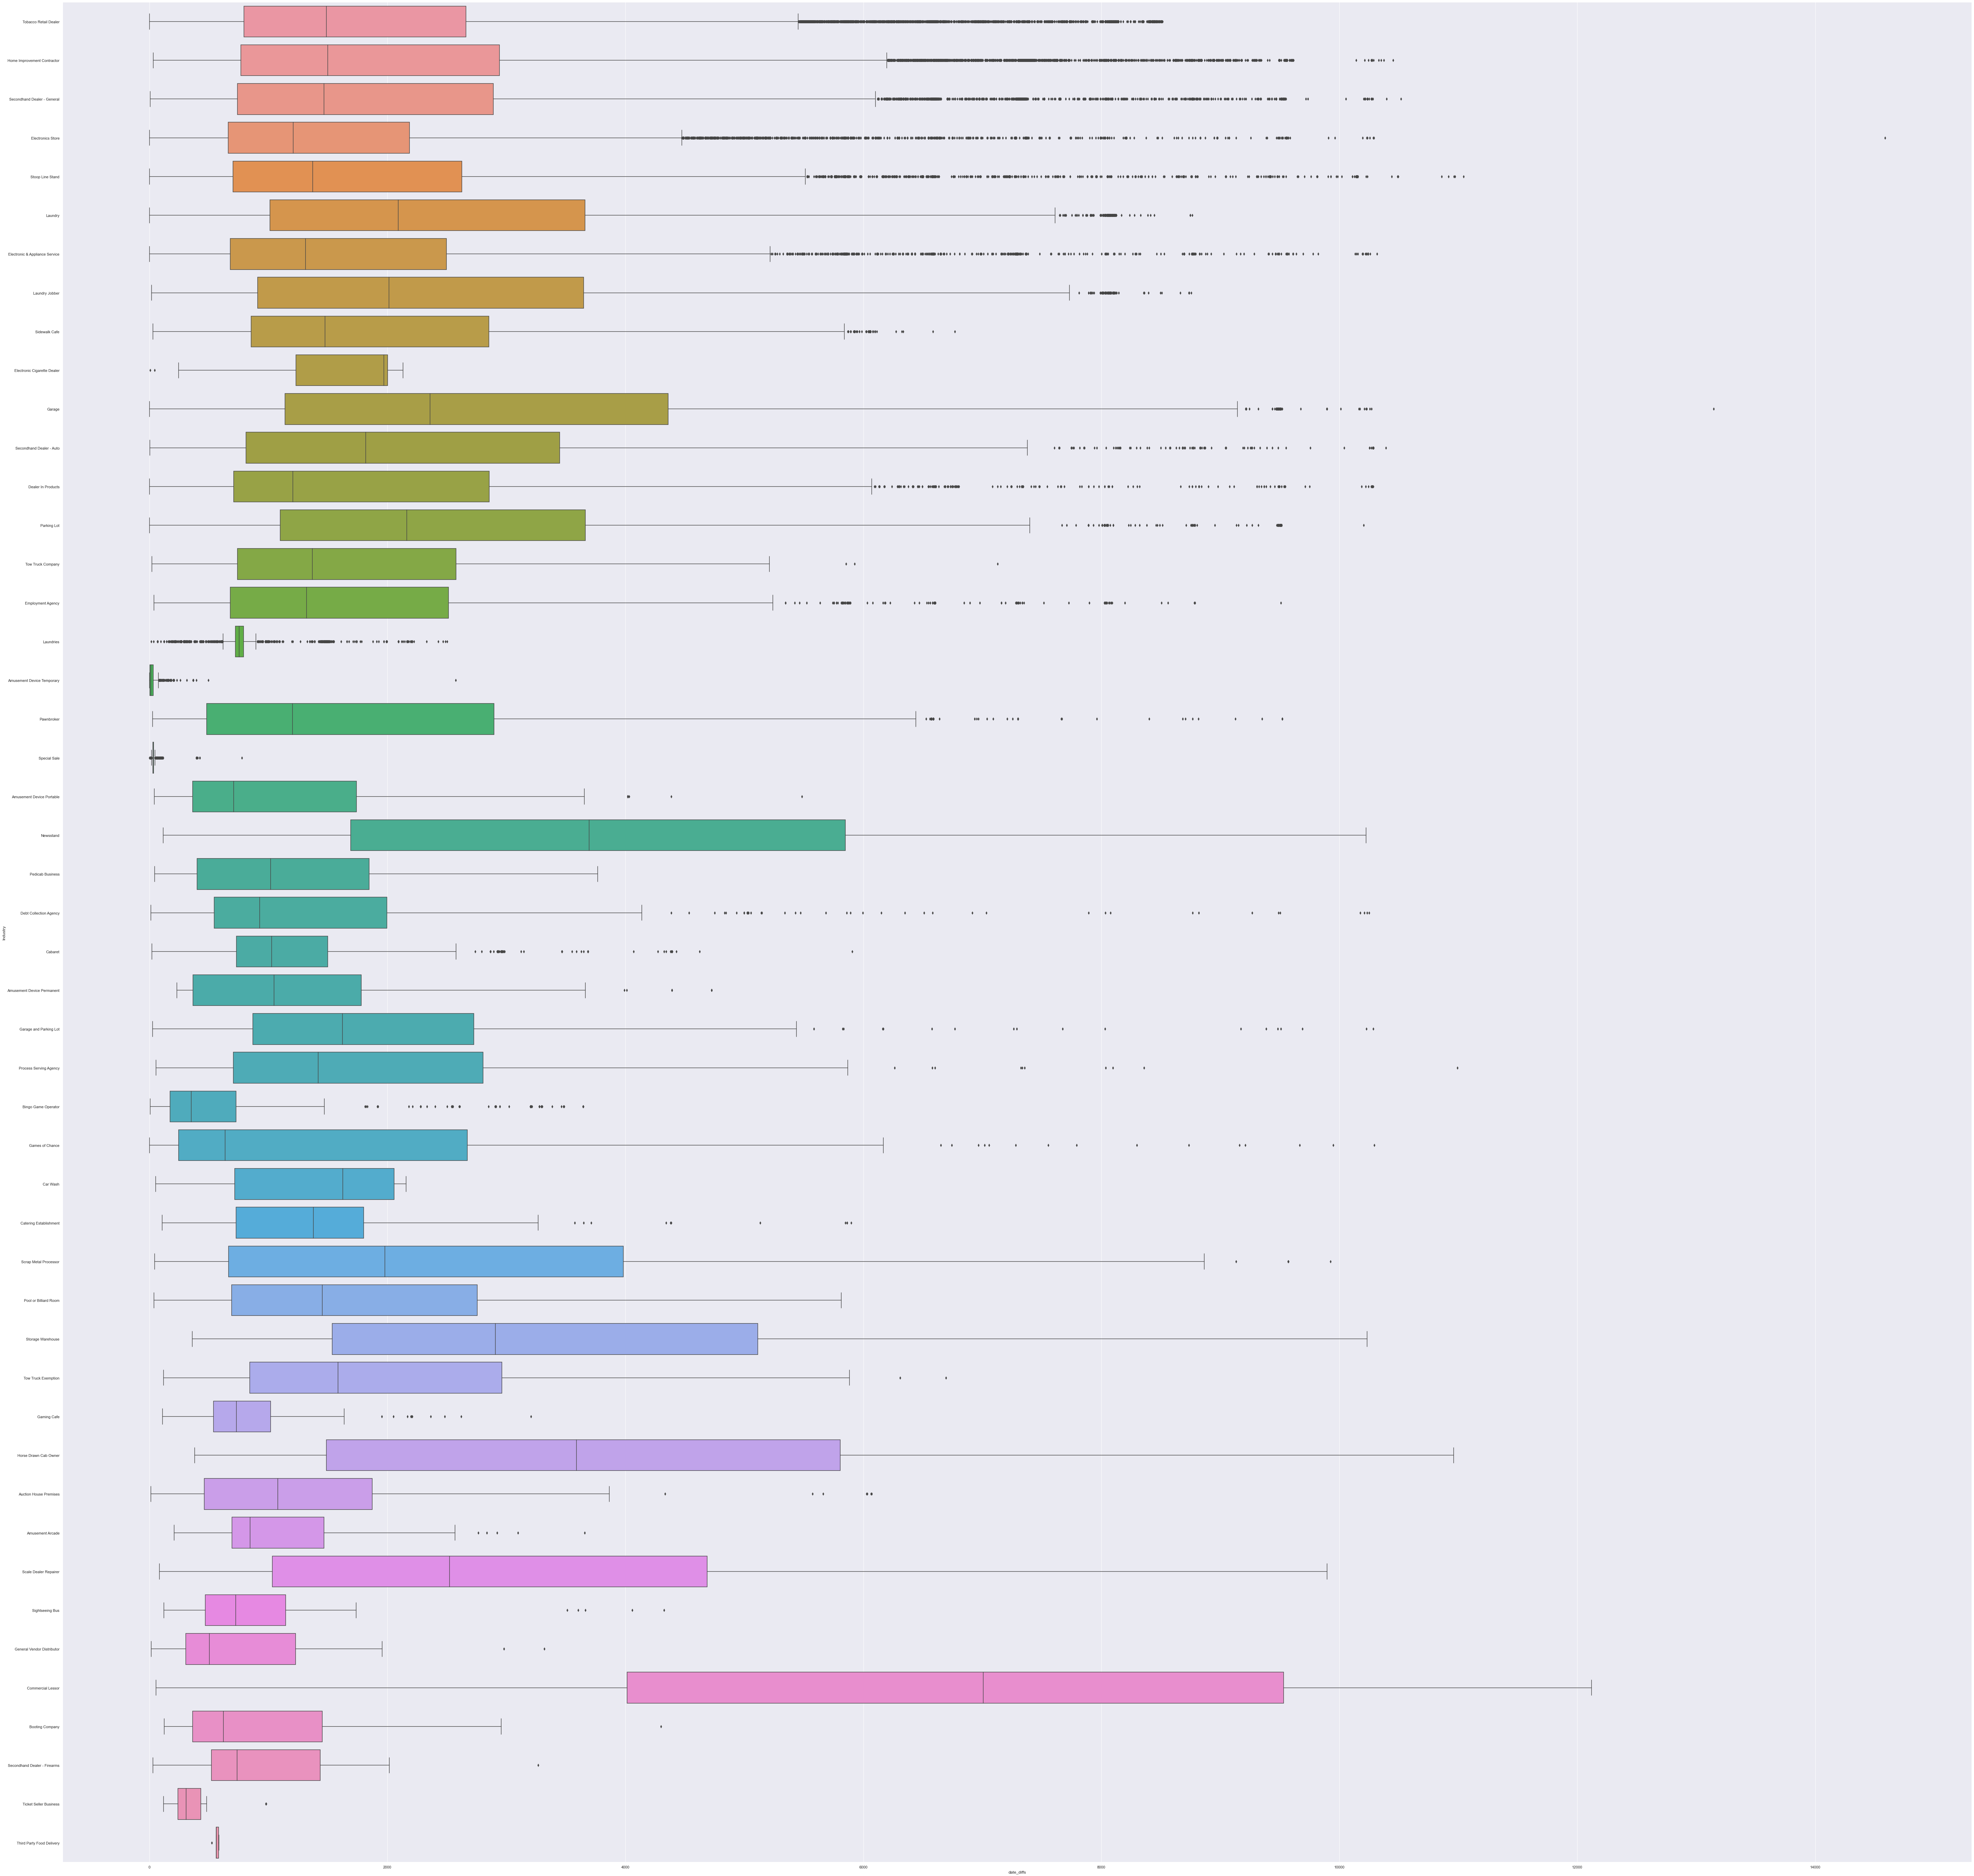

In [195]:
# Create boxplots for the duration of the license, ordered by the most popular licenses. The most common licenses have a 
# relatively comparable distribution, at least compared to the outliers.

index=df.groupby('Industry')['date_diffs'].count().sort_values(ascending=False).index
sns.boxplot(y="Industry", x="date_diffs", data=df,orient="h",order=index)

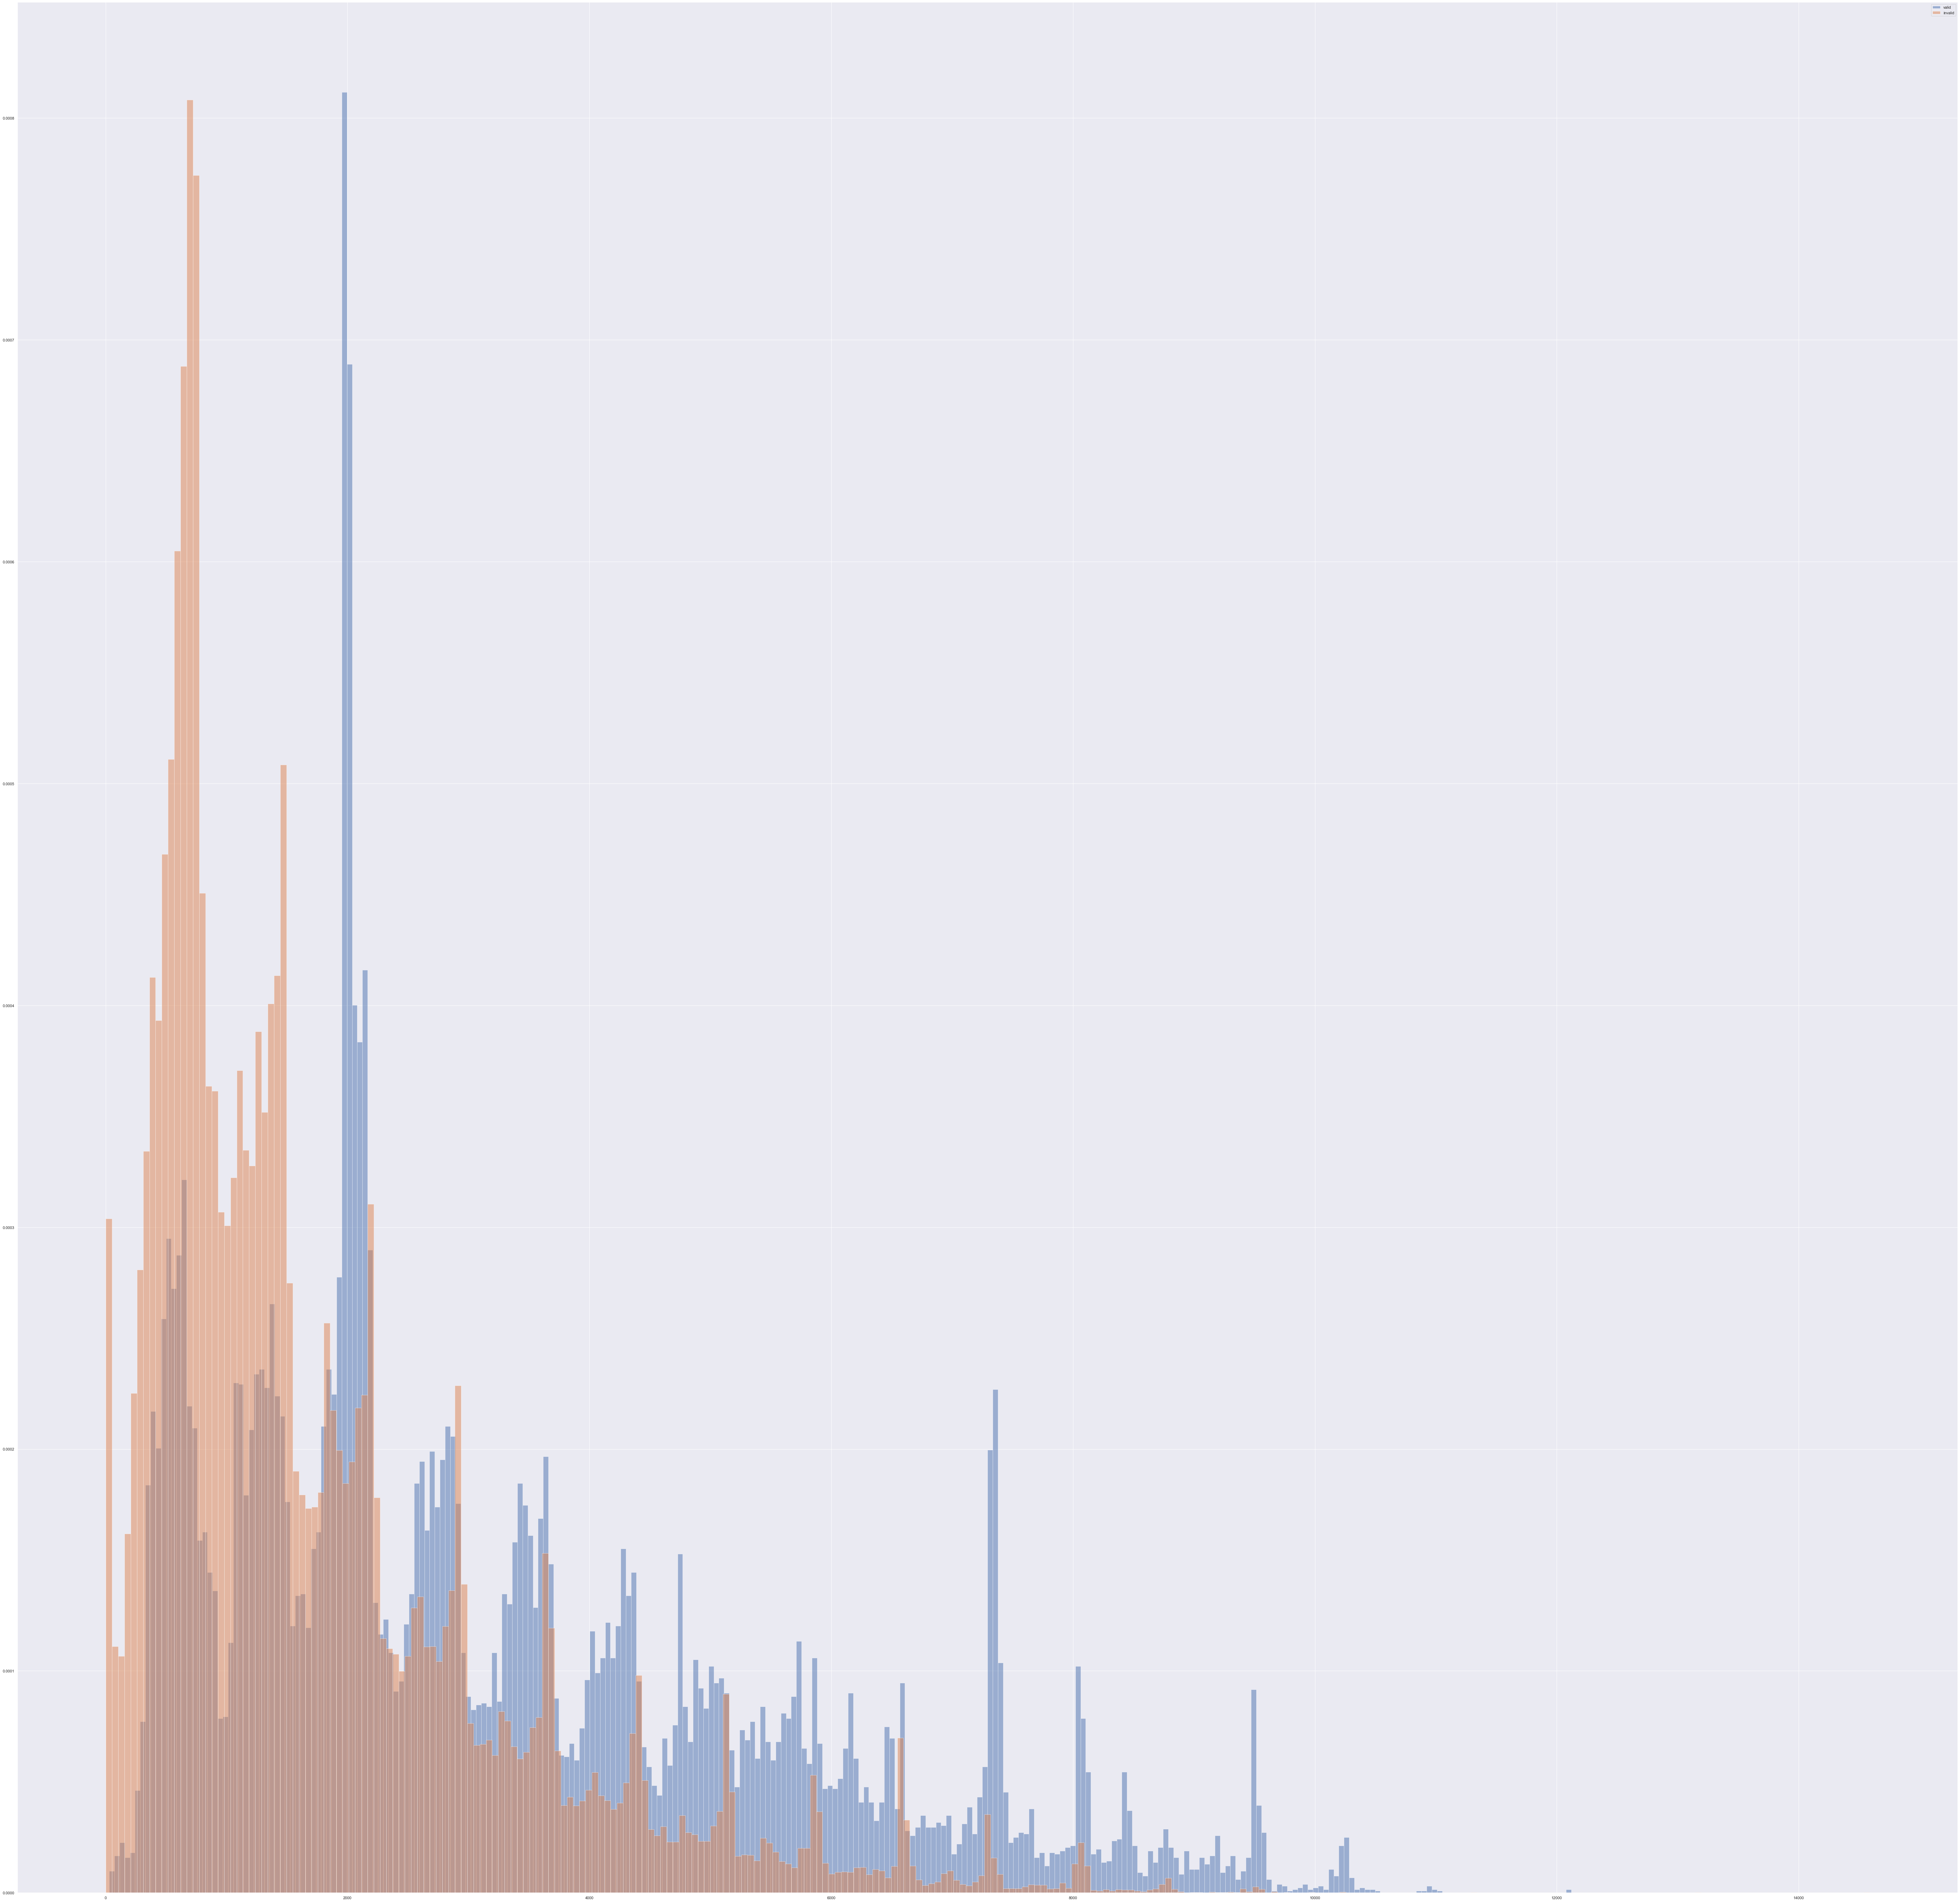

In [207]:
plt.hist(df[df['License Status']==1]['date_diffs'], 283, alpha=0.5, label='valid', density=True)
plt.hist(df[df['License Status']==0]['date_diffs'], 283, alpha=0.5, label='invalid', density=True)
plt.legend(loc='upper right')
plt.show()

In [163]:
print(df[df['License Status']==1]['date_diffs'].mean())
print(df[df['License Status']==0]['date_diffs'].mean())

# Is the difference between them significant?
stats.ttest_ind(df[df['License Status']==0]['date_diffs'],df[df['License Status']==1]['date_diffs'])

3217.528064109607
1744.7906696382543


Ttest_indResult(statistic=-138.1672315199151, pvalue=0.0)

In [166]:
# We can double check that the differences between industries are statistically significant
print('mean:',df[df['Industry']=='Tobacco Retail Dealer']['date_diffs'].mean(),'std:',df[df['Industry']=='Tobacco Retail Dealer']['date_diffs'].std())
print('Uncertainty in the average:', df[df['Industry']=='Tobacco Retail Dealer']['date_diffs'].std() / len(df[df['Industry']=='Tobacco Retail Dealer']['date_diffs']))

stats.ttest_ind(df[df['Industry']=='Tobacco Retail Dealer']['date_diffs'],df[df['Industry']=='Home Improvement Contractor']['date_diffs'])

mean: 2022.6253779585027 std: 1604.9317581385635
Uncertainty in the average: 0.04183431754088634


Ttest_indResult(statistic=-10.31148640941959, pvalue=6.519372508530571e-25)

Text(0, 0.5, 'Sum of Squares')

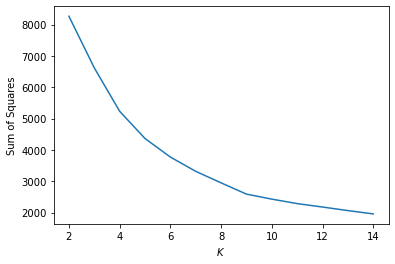

In [171]:
# We run a clustering algorithm on the points to see if there is any variance within the clusters
import sklearn
import sklearn.cluster
from sklearn import preprocessing


# Make a date that can be compared numerically to other dates
df['Start_date']=(df['License Creation Date']-np.min(df['License Creation Date'])).dt.days

X=df[['Longitude','Latitude','Start_date']].to_numpy()

# Normalize the data so that the location and time are on equal footing, as a first guess
scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(X)

ss=[]

assignments={}

Krange= list(range(2, 15))

for K in Krange:
    model = sklearn.cluster.KMeans(n_clusters=K)
    assigned_cluster = model.fit_predict(X)
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[assigned_cluster]) ** 2))
    assignments[str(K)] = assigned_cluster
    
plt.plot(Krange,ss)

plt.xlabel("$K$")
plt.ylabel("Sum of Squares")

In [174]:
# Try the square root of the number of licenses
model = sklearn.cluster.KMeans(n_clusters=412)
assigned_cluster = model.fit_predict(X)
centers = model.cluster_centers_
print(np.sum((X - centers[assigned_cluster]) ** 2))

173.48295575371313


In [175]:
# What is the average duration within a cluster?
lengths=[]
for i in range(412):
    mean=df[assigned_cluster==i]['date_diffs'].mean()
    print('For cluster ', i, 'the mean is ', mean, 'and the number of points is:', df[assigned_cluster==i].shape[0])

For cluster  0 the mean is  4894.757142857143 and the number of points is: 490
For cluster  1 the mean is  1820.2627986348123 and the number of points is: 586
For cluster  2 the mean is  1473.6100628930817 and the number of points is: 318
For cluster  3 the mean is  1903.5386666666666 and the number of points is: 375
For cluster  4 the mean is  1672.8791208791208 and the number of points is: 455
For cluster  5 the mean is  1859.0344827586207 and the number of points is: 290
For cluster  6 the mean is  1670.7671428571427 and the number of points is: 700
For cluster  7 the mean is  2282.5706896551724 and the number of points is: 580
For cluster  8 the mean is  2341.528861154446 and the number of points is: 641
For cluster  9 the mean is  1825.8325 and the number of points is: 400
For cluster  10 the mean is  1368.1061946902655 and the number of points is: 339
For cluster  11 the mean is  1289.821942446043 and the number of points is: 556
For cluster  12 the mean is  2788.1747572815534 an

For cluster  114 the mean is  1841.6898954703834 and the number of points is: 287
For cluster  115 the mean is  1245.8975 and the number of points is: 400
For cluster  116 the mean is  2157.5 and the number of points is: 328
For cluster  117 the mean is  2808.089635854342 and the number of points is: 357
For cluster  118 the mean is  1733.53663003663 and the number of points is: 546
For cluster  119 the mean is  2158.6299212598424 and the number of points is: 381
For cluster  120 the mean is  1491.909090909091 and the number of points is: 440
For cluster  121 the mean is  1358.5545023696682 and the number of points is: 422
For cluster  122 the mean is  1452.198501872659 and the number of points is: 267
For cluster  123 the mean is  2102.1359649122805 and the number of points is: 456
For cluster  124 the mean is  1720.2833333333333 and the number of points is: 180
For cluster  125 the mean is  995.9751037344398 and the number of points is: 241
For cluster  126 the mean is  1701.48503937

For cluster  235 the mean is  2099.4560143626572 and the number of points is: 557
For cluster  236 the mean is  2718.62763915547 and the number of points is: 521
For cluster  237 the mean is  3337.63184079602 and the number of points is: 201
For cluster  238 the mean is  2128.4174528301887 and the number of points is: 424
For cluster  239 the mean is  3586.5151515151515 and the number of points is: 264
For cluster  240 the mean is  2478.2110817941953 and the number of points is: 379
For cluster  241 the mean is  2153.4632653061226 and the number of points is: 490
For cluster  242 the mean is  1692.8988235294119 and the number of points is: 425
For cluster  243 the mean is  2123.7325 and the number of points is: 400
For cluster  244 the mean is  1344.3963133640552 and the number of points is: 434
For cluster  245 the mean is  1784.4944320712696 and the number of points is: 898
For cluster  246 the mean is  1344.5709677419354 and the number of points is: 310
For cluster  247 the mean is 

For cluster  358 the mean is  2478.8408551068883 and the number of points is: 421
For cluster  359 the mean is  2501.6082474226805 and the number of points is: 194
For cluster  360 the mean is  1899.5933609958506 and the number of points is: 241
For cluster  361 the mean is  651.7312925170068 and the number of points is: 294
For cluster  362 the mean is  1730.3544776119404 and the number of points is: 536
For cluster  363 the mean is  2120.310218978102 and the number of points is: 274
For cluster  364 the mean is  2181.2021857923496 and the number of points is: 183
For cluster  365 the mean is  1240.985257985258 and the number of points is: 407
For cluster  366 the mean is  4976.340248962656 and the number of points is: 241
For cluster  367 the mean is  2337.0401785714284 and the number of points is: 224
For cluster  368 the mean is  724.56875 and the number of points is: 160
For cluster  369 the mean is  4480.8125 and the number of points is: 336
For cluster  370 the mean is  1626.394

In [176]:
# Is the difference between clusters statistically significant?
stats.ttest_ind(df[assigned_cluster==3]['date_diffs'],df[assigned_cluster==1]['date_diffs'])

Ttest_indResult(statistic=0.8785975765836891, pvalue=0.37983958633675097)

In [177]:
# Most of the clusters have statistically significant differences
total=0
for i in range(412):
    if(stats.ttest_ind(df[assigned_cluster==8]['date_diffs'],df[assigned_cluster==i]['date_diffs']).pvalue*100 > 5):
        total=total+1
print(total)

75


In [178]:
# Assign to each license the mean within its cluster

means=[]

for i in range(412):
    means.append(df[assigned_cluster==i]['date_diffs'].mean())

In [216]:
df['Mean_Neighbors']=0
for i in range(412):
    df.loc[assigned_cluster==i,'Mean_Neighbors']=means[i]

In [238]:
# Now we can test if the cluster mean gives valuable information
# As a proof of concept we will see test the model generated vs one that uses only
# the type of license and another that uses the location also

X_Industry_Only=pd.get_dummies(df['Industry'],'Industry')
X_Industry_And_Location=pd.get_dummies(df[['Longitude','Latitude','Industry']],'Industry')
X_Means=pd.get_dummies(df[['Longitude','Latitude','Industry','Mean_Neighbors']],'Industry')
y=df['date_diffs']

In [219]:
# Generate the sample for each model
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_Industry_Only, y, test_size=0.2, random_state=123)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_Industry_And_Location, y, test_size=0.2, random_state=123)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_Means, y, test_size=0.2, random_state=123)


In [220]:
from sklearn import datasets
from sklearn import metrics
import xgboost as xgb


model1 = xgb.XGBRegressor()
model1.fit(X_train1, y_train1)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [221]:
# The RMSE for only the business license type
from sklearn.metrics import mean_squared_error as MSE

pred1 = model1.predict(X_test1)
rmse1 = np.sqrt(MSE(y_test1, pred1))
print("RMSE : % f" %(rmse1))

RMSE :  1730.770851


In [222]:
# The RMSE including location

model2 = xgb.XGBRegressor()
model2.fit(X_train2, y_train2)
pred2 = model2.predict(X_test2)
rmse2 = np.sqrt(MSE(y_test2, pred2))
print("RMSE : % f" %(rmse2))

RMSE :  1714.769326


In [223]:
# The RMSE including the mean within the cluster
# The result is promising!

model3 = xgb.XGBRegressor()
model3.fit(X_train3, y_train3)
pred3 = model3.predict(X_test3)
rmse3 = np.sqrt(MSE(y_test3, pred3))
print("RMSE : % f" %(rmse3))

RMSE :  1502.466729


In [239]:
# Cross validation across the three different models

from sklearn.model_selection import cross_val_score
model_only_industry=xgb.XGBRegressor()
model_locations=xgb.XGBRegressor()
model_all=xgb.XGBRegressor()

score_only_industry= cross_val_score(model_only_industry, X_Industry_Only, y, cv=5,scoring='neg_root_mean_squared_error')
score_locations=cross_val_score(model_locations, X_Industry_And_Location, y, cv=5,scoring='neg_root_mean_squared_error')
score_all=cross_val_score(model_all, X_Means, y, cv=5,scoring='neg_root_mean_squared_error')

print("RMSE for industry: %0.2f" % score_only_industry.mean())
print("RMSE for locations: %0.2f" % score_locations.mean())
print("RMSE for means:%0.2f" % score_all.mean())

-1750.26 explained variance for industry
-1738.89 explained variance for locations
-1707.69 explained variance for means


In [245]:
# Adding the cluster average does not help the model that much
# Finally, we can add the license status to see if that will help our model out

X_best=pd.get_dummies(df[['License Status','Longitude','Latitude','Industry','Mean_Neighbors']],'Industry')
scores=cross_val_score(xgb.XGBRegressor(), X_best, y, cv=5,scoring='neg_root_mean_squared_error')

In [246]:
scores.mean()

-1256.0748021165944

In [252]:
X_not_as_good=pd.get_dummies(df[['License Status','Longitude','Latitude','Industry']],'Industry')
scores_bad=cross_val_score(xgb.XGBRegressor(), X_not_as_good, y, cv=5,scoring='neg_root_mean_squared_error')

In [253]:
scores_bad.mean()

-1613.0138032123382

In [ ]:
# So adding the cluster mean does indeed seem to improve the model quite a bit
# Of course, the model would have to be tuned, not to mention we would have to find the right number of clusters!
# But as proof of concept this result is good